# Image Classification using Machine Learning Techniques
*By JarredR*  
This project will use the [ImageWoof dataset](https://github.com/fastai/imagenette#imagewoof), which is made up of 12,000 images of dogs divided into 10 classes (breeds). The goal is to classify images of dogs into the correct class with the accuracy metric being the measure of performance. To achieve this goal, a variety of conventional machine learning and deep learning techniques will be compared. The same techniques from this project were used in the major project, which instead used the CelebA dataset and the classfication task was hair colour prediction. The results will be compared this project and the major project throughout this notebook, particually in the discussion section.


## Notebook Outline
* **Data Preprocessing:** In this section the data is preprocessed for use in the later experiments.
* **Data Exploration:** In this section the distribution of the dataset is explored and individual images visualised.
* **Conventional Machine Learning:** In this section, some conventional machine learning models are trained and evaluated as baseline results.
* **Deep Learning:** In this section, some deep learning models are trained and evaluated, with their results compared to those of conventional techniques.
* **Larger Data:** In this section, the effect of using larger training images, with 224 \* 224 pixels instead of 48 \* 48, are explored and compared with the previous deep learning results.
* **Transfer Learning:** In this section, transfer learning is tested and compared with the deep learning results.
* **Discussion:** In this section, the results are discussed and compared with the major project.

# Data Preprocessing
In this section, the data is loaded in from disk and preprocessed for use in sklearn conventional machine learning models and Keras deep learning models.  
The preprocessing includes:
* Loading from disk the ImageWoof data which has already been split into train and test sets.
* The values in the data are normalized as floats between 0 and 1.

In [10]:
%matplotlib inline

import glob
import numpy as np
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
import keras
from keras.layers import Dropout, Flatten, Convolution2D, ZeroPadding2D, MaxPooling2D, Dense, GlobalAveragePooling2D, \
    Activation
from keras.models import Sequential, Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

In [2]:
def data_loader(base_path, for_sklearn, img_dim, num_classes):
    """Loads the train and test sets of the Imagewoof dataset

    Args:
        base_path: A string providing the base path for the dataset
        for_sklearn: A boolean for whether to format the data for sklearn models
        img_dim: Number of dimensions in the image
        num_classes: The number of classes (breeds) to use
    Returns:
        Numpy arrays for the train and test sets plus the classes of the label encoder
    """

    def flatten_data(data):
        """Flattens the dimensions of the data for sklearn models

        Args:
            data: A multi-dimensional numpy array of image pixels to be flattened

        Returns:
            Data reshaped into one dimension
        """
        samples, dim1, dim2, alpha = data.shape
        data = data.reshape(samples, dim1 * dim2 * alpha)
        return data

    def load_image(image_path):
        """Loads an image from file and scales it

        Args:
            image_path: The path of the image on disk

        Returns:
            A numpy array of pixel values representing the image
        """
        img = image.load_img(image_path, grayscale=False, target_size=(img_dim, img_dim))
        x = image.img_to_array(img, dtype='float32')
        return x

    def load_dataset(breed_paths):
        """Loads all the images in a directory and normalizes them

        Args:
            breed_paths: A list of paths to the directories of each dog breed

        Returns:
            A numpy array of images in the dataset and a list of labels of the images in x
        """
        x = []
        y = []
        for i in range(num_classes):
            breed = breed_paths[i]
            breed_class = breed[-9:]
            image_paths = glob.glob(breed + '/*')
            for image_path in image_paths:
                x.append(load_image(image_path))
                y.append(breed_class)
        x = np.array(x)
        x /= 255
        return x, y

    print('Loading data...')
    train_paths = glob.glob(base_path + '/train/*')
    test_paths = glob.glob(base_path + '/val/*')
    x_train, y_train = load_dataset(train_paths)
    x_test, y_test = load_dataset(test_paths)
    if for_sklearn:
        x_train = flatten_data(x_train)
        x_test = flatten_data(x_test)
        encoder = LabelEncoder()
    else:
        encoder = LabelBinarizer()
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)
    print('Finished loading data')
    return x_train, y_train, x_test, y_test, encoder.classes_

In [5]:
img_dim = 48
num_classes = 10
x_train, y_train, x_test, y_test, encoder_classes = data_loader('./data/imagewoof', for_sklearn=False,
                                                                img_dim=img_dim, num_classes=num_classes)

Loading data...
Finished loading data


# Data Exploration
## Class Distribution

It's important to know the distribution of the classes to judge the accuracy of the models correctly. For example, if one class made up 90% of the images in the train and test sets, a high accuracy could be achieved simply by always guessing the correct class. Models trained on unbalanced data are also not likely to perform as well on data matching other classes.

In [6]:
imagenet_classes = {
        'n02115641': 'Dingo',
        'n02111889': 'Samoyed',
        'n02105641': 'Old English Sheepdog',
        'n02099601': 'Golden Retriever',
        'n02096294': 'Australian Terrier',
        'n02093754': 'Border Terrier',
        'n02089973': 'English Foxhound',
        'n02088364': 'Beagle',
        'n02087394': 'Rhodesian Ridgeback',
        'n02086240': 'Shih-Tzu'
    }


def get_class(prediction, classes):
    """Gets the class name of a prediction or label

    Args:
        prediction: A one-hot numpy array
        classes: the classes from the encoder

    Returns:
        The English name of the prediction or label
    """
    return imagenet_classes[classes[np.argmax(prediction)]]


def class_distribution(labels, classes):
    """Prints the distribution of classes in a dataset
    
    Args:
        labels: the true labels for the data
        classes: the classes from the encoder
        
    Returns:
        Nothing
    """
    label_counts = {}
    for label in labels:
        class_name = get_class(label, classes)
        if class_name in label_counts:
            label_counts[class_name] += 1
        else:
            label_counts[class_name] = 1
    
    for dog_breed, count in label_counts.items():
        print(f'{dog_breed}: {count}')

In [7]:
print('Train distribution:')
class_distribution(y_train, encoder_classes)
print('\nTest distribution:')
class_distribution(y_test, encoder_classes)

Train distribution:
English Foxhound: 580
Shih-Tzu: 941
Old English Sheepdog: 928
Border Terrier: 949
Beagle: 932
Rhodesian Ridgeback: 942
Australian Terrier: 943
Samoyed: 921
Dingo: 940
Golden Retriever: 949

Test distribution:
English Foxhound: 224
Shih-Tzu: 409
Old English Sheepdog: 422
Border Terrier: 401
Beagle: 418
Rhodesian Ridgeback: 408
Australian Terrier: 407
Samoyed: 429
Dingo: 410
Golden Retriever: 401


### Distribution Results

From the distribution analysis we can see that all the classes except the English Foxhound have approximately equal numbers of instances. The English foxhound has about 60% the amount of the other classes which is fine in this instance. This dataset is quite well balanced.

## Visualising Images

Visualising some of the images in the dataset will give us a feel for what our models will be working with and ensure we've encoded the images in the correct way.

In [11]:
def display_image(img):
    """Displays an array of pixels as an image

    Args:
        img: an array of pixels
    """
    restored_img = img * 255
    pil_img = Image.fromarray(restored_img.astype(np.uint8))
    plt.axis('off')
    plt.imshow(pil_img)

    
def plot_image(img, label):
    print(get_class(label, encoder_classes))
    display_image(img)

English Foxhound


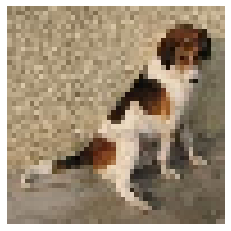

In [12]:
plot_image(x_train[0], y_train[0])

Shih-Tzu


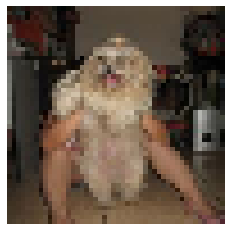

In [13]:
plot_image(x_train[1000], y_train[1000])

Old English Sheepdog


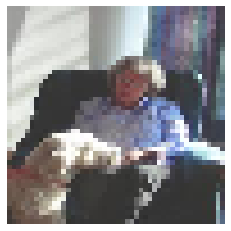

In [14]:
plot_image(x_train[2000], y_train[2000])

### Visualisation Results

As we can see, the images are not just close up portraits of the dogs which are facing the camera. This dataset is quite messy and there's often people and other objects in the images. This means that it is quite unlikely models will be getting perfect accuracy on the test set. The images are quite pixelated at 48 * 48, and therefore humans may have difficulty identifying the breed, but images of this size will be suited to small to medium models.

# Conventional Machine Learning
Many conventional machine learning techniques are not suitable for the high dimensionality of image data. For example, images of size 224 * 224 have 150,528 dimensions when the RGB channels are factored in. The decision trees and k-nearest neighbors algorithms are particually not suitable because they work best with a small number of features which are highly relevant to classification. The only suitable options are logistic regression and support vector machines classifiers.

SKlearn models only allow for one dimesional input, so the images have to be preprocessed differently than from the keras models in later sections.

## First Attempt
To demonstrate how conventional machine learning approaches struggle with high dimensional data, images of size 224 * 224 will be used first. This experiment is likely to yeild poor results.

In [15]:
def evaluate_model(model, x_train, y_train, x_test, y_test):
    """Trains a model and prints the train and test accuracy.

    Args:
        model: an sklearn model to be trained and evaluated
        x_train: train set of images
        y_train: labels of train set
        x_test: test set of images
        y_test: labels of test set

    Returns:
        The trained model
    """
    print('Training model...')
    model.fit(x_train, y_train)
    print('Evaluating model...')
    print(f'Train accuracy: {model.score(x_train, y_train)}')
    print(f'Test accuracy: {model.score(x_test, y_test)}')
    return model

In [21]:
img_dim = 224
num_classes = 10

sx_train, sy_train, sx_test, sy_test, encoder_classes = data_loader('./data/imagewoof', for_sklearn=True)

In [22]:
lr_model = LogisticRegression(max_iter=100)

print('Logistic Regression:')
evaluate_model(lr_model, x_train, y_train, x_test, y_test)

Training model...  
Evaluating model...  
Train accuracy: 0.545  
Test accuracy: 0.252

In [23]:
svm_model = SGDClassifier()

print('SVM:')
evaluate_model(svm_model,  x_train,y_train, x_test, y_test)

Training model...  
Evaluating model...  
Train accuracy: 0.865  
Test accuracy: 0.203

### First Attempt Results

The 10 class classification has a random chance accuracy 0.1, so the models are learning something but the performance is very poor. The huge gap between the train and test accuracies demonstrate that the models are not generalising to new data well. The SVM model also has a huge 66% gap between the train and test accuracy which indicates it is very poor at generalising to new data and has overfit.

## Second Attempt
For the next experiment, the size of the images will be brought down to 48x48 and the number of classes to 4 to make the task more comparable to that of the major project. The expecation is that the accuracy result will be significantly higher than the first attempt.

In [24]:
img_dim = 48
num_classes = 4

sx_train, sy_train, sx_test, sy_test, encoder_classes = data_loader('./data/imagewoof', for_sklearn=True)

In [25]:
lr_model = LogisticRegression(max_iter=100)

print('Logistic Regression:')
evaluate_model(lr_model)

Training model...  
Evaluating model...  
Train accuracy: 0.813  
Test accuracy: 0.492

In [26]:
svm_model = SGDClassifier()

print('SVM:')
evaluate_model(svm_model)

Training model...  
Evaluating model...  
Train accuracy: 0.906  
Test accuracy: 0.463

### Second Attempt Results

There's a definite improvement in the test accuracy for both the logisitic regression and svm models, however there's a large gap between the train and test accuracy which indicates that the models are overfitting to the training data and not generalising well. The fact that the accuracy is still below 0.5 indicates that the classification of the dog breeds is more difficult than the hair colour classification task in the major project. From the visualisation of a few of the images in the dataset earlier, it makes sense that these models would perform worse on this task than on hair colour classification as humans may also struggle with it.

# Deep Learning
Deep learning is much better suited for image datasets and is therefore likely to achieve superior results than conventional machine learning.

## cnn Model
This model has four convolutional layers, split into two groups, with a max pooling layer after each group. It has two dropout layers to prevent overfitting, and a single dense layer of size 128 with a ReLU activation, before the softmax classification layer at the end. The architecture is inspired by that of VGG Face, but with only a quarter of the layers. This model performed very well in the major project on the hair colour classification task.

In [27]:
def cnn(x_train, y_train, x_test, y_test, epochs, img_dim, num_classes):
    cnn_model = Sequential()
    cnn_model.add(ZeroPadding2D((1, 1), input_shape=(img_dim, img_dim, 3)))
    cnn_model.add(Convolution2D(32, (3, 3), activation='relu'))
    cnn_model.add(ZeroPadding2D((1, 1)))
    cnn_model.add(Convolution2D(32, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

    cnn_model.add(ZeroPadding2D((1, 1)))
    cnn_model.add(Convolution2D(64, (3, 3), activation='relu'))
    cnn_model.add(ZeroPadding2D((1, 1)))
    cnn_model.add(Convolution2D(64, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

    cnn_model.add(Dropout(0.5))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(128, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(num_classes, activation='softmax'))

    cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=keras.optimizers.Adam(),
                      metrics=['accuracy']
                      )

    cnn_model.fit(x_train, y_train, epochs=epochs, batch_size=256)
    score = cnn_model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

### large_cnn Model
This model is based off cnn, but with an extra block of two convolutional layers to bring the total to 6. This model adds a third dropout layer to try to reduce overfitting, and an additional dense layer with ReLU activation. This model will take longer to train than cnn due to the extra layers: will this training lead to an improvement in performance or overfitting to the training data? We shall find out.
This model performed the best in the major project on the hair colour classification task.

In [28]:
def large_cnn(x_train, y_train, x_test, y_test, epochs, img_dim, num_classes):
    cnn_model = Sequential()
    cnn_model.add(ZeroPadding2D((1, 1), input_shape=(img_dim, img_dim, 3)))
    cnn_model.add(Convolution2D(32, (3, 3), activation='relu'))
    cnn_model.add(ZeroPadding2D((1, 1)))
    cnn_model.add(Convolution2D(32, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

    cnn_model.add(ZeroPadding2D((1, 1)))
    cnn_model.add(Convolution2D(64, (3, 3), activation='relu'))
    cnn_model.add(ZeroPadding2D((1, 1)))
    cnn_model.add(Convolution2D(64, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

    cnn_model.add(ZeroPadding2D((1, 1)))
    cnn_model.add(Convolution2D(128, (3, 3), activation='relu'))
    cnn_model.add(ZeroPadding2D((1, 1)))
    cnn_model.add(Convolution2D(128, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

    cnn_model.add(Dropout(0.5))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(256, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(128, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(num_classes, activation='softmax'))

    cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=keras.optimizers.Adam(),
                      metrics=['accuracy']
                      )

    cnn_model.fit(x_train, y_train, epochs=epochs, batch_size=256)
    score = cnn_model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

## 4 Class Classification Experiments

In [29]:
img_dim = 48
num_classes = 4
epochs = 50
x_train, y_train, x_test, y_test, encoder_classes = data_loader('./data/imagewoof', for_sklearn=False, 
                                                                img_dim=img_dim, num_classes=num_classes)

In [30]:
cnn(x_train, y_train, x_test, y_test, epochs=epochs, img_dim=img_dim, num_classes=num_classes)

Training model...  
Train loss: 0.144  
Train accuracy: 0.984  
Test loss: 1.28  
Test accuracy: 0.693

In [31]:
large_cnn(x_train, y_train, x_test, y_test)

Training model...  
Train loss: 0.1831  
Train accuracy: 0.9357  
Test loss: 1.13  
Test accuracy: 0.722

## 10 Class Classification Experiments

In [32]:
img_dim = 48
num_classes = 10
epochs = 50
x_train, y_train, x_test, y_test, encoder_classes = data_loader('./data/imagewoof', for_sklearn=False, 
                                                                img_dim=img_dim, num_classes=num_classes)

In [33]:
cnn(x_train, y_train, x_test, y_test, epochs=epochs, img_dim=img_dim, num_classes=num_classes)

Training model...  
Train loss: 0.611  
Train accuracy: 0.783  
Test loss: 1.86  
Test accuracy: 0.453

In [34]:
large_cnn(x_train, y_train, x_test, y_test)

Training model...  
Train loss: 0.499  
Train accuracy: 0.826  
Test loss: 1.86  
Test accuracy: 0.507

## Results
The deep learning models performed significantly better than the conventional machine learning approaches. Using large_cnn for 4 class classification, accuracy improved by 22% over logistic regression, while 10 class classification accuracy improved by 25%. large_cnn performed better at both 4 and 10 class classification than cnn, and the difference was more pronounced with 10 class. This is likely because the extra model size allowed for a better decision function to be learned.

Although these results represent a huge performance increase, overall the models predictions are still quite unreliable. At 10 class classification the best test accuracy is only 0.5, therefore there is still significant room for improvement. There is also about a 30% difference in accuracy between the train and test accuracy results of these models, this indicates that their decision functions are not great at generalising to new data.

Cnn and large_cnn were each tested at 40, 50, and 60 epochs. The models started overfitting at 60 epochs, with test accuracy dropping by approximately 1% in all tests compared to 50 epochs, while at 70 epochs test accuracy fell by approximately 3%. Models underfit at 40 epochs, getting approximately 1 % lower test accuracy than 50 epochs. Therefore 50 epochs was kept for the final results.

These same models, cnn and large_cnn, were able to achive more than 90% accuracy on the 4 class hair colour classification problem of the major project. This is further evidence that dog breed classification is a more difficult task.

# Large Data
In this section, the effect of the size of the images will be explored. In the earlier deep learning tests, the images of ImageWoof were scaled down to 48 * 48 pixels. This would have resulted in a significant amount of information being lost from the original images, as demonstrated in the visualisation of the blocky images in the data preprocessing section. This time the images will be scaled to the size of 224 * 224, which will significantly increase the model training times, but potentially give better results. This section will investigate whether it's worth it to use the larger images for CNNs of this size.

## Large Data Visualisation

In [36]:
img_dim = 224
num_classes = 10
x_train, y_train, x_test, y_test, encoder_classes = data_loader('./data/imagewoof', for_sklearn=False, 
                                                                img_dim=img_dim, num_classes=num_classes)


Loading data...
Finished loading data


English Foxhound


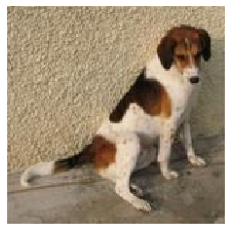

In [37]:
plot_image(x_train[0], y_train[0])

Shih-Tzu


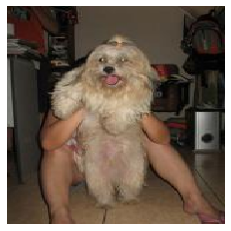

In [38]:
plot_image(x_train[1000], y_train[1000])

Old English Sheepdog


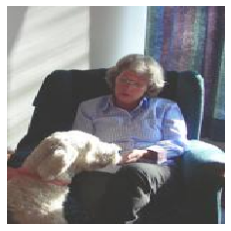

In [39]:
plot_image(x_train[2000], y_train[2000])

### Visualisation Results
The larger 224 \* 224 images are much less pixelated than the 48 \* 48 images, which will definitely help a human in correctly identifying a breed of dog. But will it make much of a difference to machine learning models?

### 4 Class Classification
cnn and large_cnn will be trained and tested on the reduced 4 class classification problem for 50 epochs, the same as the small data test.

In [40]:
img_dim = 224
num_classes = 4
epochs = 50
x_train, y_train, x_test, y_test, encoder_classes = data_loader('./data/imagewoof', for_sklearn=False, 
                                                                img_dim=img_dim, num_classes=num_classes)

In [41]:
cnn(x_train, y_train, x_test, y_test, epochs=epochs, img_dim=img_dim, num_classes=num_classes)

Training model...  
Train loss: 0.255  
Train accuracy: 0.892  
Test loss: 1.740  
Test accuracy: 0.652

In [42]:
large_cnn(x_train, y_train, x_test, y_test, epochs=epochs, img_dim=img_dim, num_classes=num_classes)

Training model...  
Train loss: 0.121  
Train accuracy: 0.959  
Test loss: 1.486  
Test accuracy: 0.690

### 10 Class Classification
cnn and large_cnn will be trained and tested on the full 10 class classification problem for 50 epochs, the same as the small data test.

In [43]:
img_dim = 224
num_classes = 10
epochs = 50
x_train, y_train, x_test, y_test, encoder_classes = data_loader('./data/imagewoof', for_sklearn=False, 
                                                                img_dim=img_dim, num_classes=num_classes)

In [44]:
cnn(x_train, y_train, x_test, y_test, epochs=epochs, img_dim=img_dim, num_classes=num_classes)

Training model...  
Train loss: 0.289  
Train accuracy: 0.886  
Test loss: 3.467  
Test accuracy: 0.366

In [45]:
large_cnn(x_train, y_train, x_test, y_test, epochs=epochs, img_dim=img_dim, num_classes=num_classes)

Training model...  
Train loss: 0.361  
Train accuracy: 0.875  
Test loss: 2.194  
Test accuracy: 0.429

## Large Data Results
Both cnn and large_cnn performed worse with the large 224 * 224 data than with the small 48 * 48 data. For 4 class classification, the drop in accuracy was around 3%, while for 10 classification there was a drop of about 8%. This result is somewhat counter-intuitive: the larger input images had more information so theoretically models should perform better on them. The likely reason why performance dropped was that cnn and large_cnn did not have large enough model capacities to learn from these significantly larger inputs. The fact that 10 class classification had a larger drop in accuracy may support this theory, as the decision function for 10 class classification is more complicated and requires a larger model capacity that 4 class. The transfer learning section will feature models with much higher capacities which should handle the large data well.

# Transfer Learning
In this section, transfer learning will be explored to see if the results of the deep learning section can be improved. Two huge pre-trained models, VGG Face and ResNet50, will be used to test transfer learning. These models are very deep, with VGG Face having 16 layers and ResNet50 having 50 layers. They have been pretrained with huge datasets such as imagenet, and that training would have taken very significant computational power to do. The idea is that some of the learning from the pre-training will be able to transfer over to our dog breed classification task as ImageWoof is a much smaller dataset than ImageNet. Most of the layers of these networks will be frozen with the pre-trained weights, and then will be trained a bit more using ImageWoof. These results will then be compared with small and medium CNN from the deep learning section. As VGG Face and ResNet50 were both trained with large image sizes, the large ImageWoof images from the previous section will be used for training.

## VGG Face
In this experiment, the [VGG Face](https://www.robots.ox.ac.uk/~vgg/software/vgg_face/) model will be used to test transfer learning. This code is based on a port of VGG face to Keras by [Sefik Ilkin Serengil](https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/). The last three convolutional layers will be left trainable, with all earlier layers being frozen to their pre-trained weights. VGG Face is specifically trained on images of human faces, so it will be interesting to see if anything transfers to images of dogs. This same setup was used in the major project, which unfortunately had inferior results to the cnn and large_cnn models. 

In [46]:
def vgg_face(x_train, y_train, x_test, y_test, epochs, num_classes):
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool1'))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool2'))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool3'))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool4'))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool5'))
    # By default, layers beyond this are trainable
    model.add(Convolution2D(4096, (7, 7), activation='relu', name='fc6'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu', name='fc7'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1), name='fc8'))
    model.add(Flatten())
    model.add(Activation('softmax'))

    # pre-trained weights of vgg-face model.
    # you can find it here: https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
    # related blog post: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
    model.load_weights('data/vgg_face_weights.h5')

    for layer in model.layers[:-7]:
        layer.trainable = False

    vgg_face_output = Sequential()
    vgg_face_output = Convolution2D(num_classes, (1, 1), name='predictions')(model.layers[-4].output)
    vgg_face_output = Flatten()(vgg_face_output)
    vgg_face_output = Activation('softmax')(vgg_face_output)

    vgg_face_model = Model(inputs=model.input, outputs=vgg_face_output)

    vgg_face_model.compile(loss='categorical_crossentropy',
                           optimizer=keras.optimizers.Adam(),
                           # optimizer = sgd,
                           metrics=['accuracy']
                           )

    vgg_face_model.fit(x_train, y_train, epochs=epochs, batch_size=32)
    model.save_weights('./data/vgg_face_checkpoint')
    score = vgg_face_model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

### 4 Class Classification
VGG Face will be trained and tested on the reduced 4 class classification problem with 3, 5, and 10 epochs of training.

In [47]:
img_dim = 224
num_classes = 4
x_train, y_train, x_test, y_test, encoder_classes = data_loader('./data/imagewoof', for_sklearn=False, 
                                                                img_dim=img_dim, num_classes=num_classes)

In [48]:
epochs = 3
vgg_face(x_train, y_train, x_test, y_test, epochs=epochs, img_dim=img_dim, num_classes=classes)

Training model...  
Train loss: 0.244  
Train accuracy: 0.910  
Test loss: 1.120  
Test accuracy: 0.700

In [51]:
epochs = 5
vgg_face(x_train, y_train, x_test, y_test, epochs=epochs, img_dim=img_dim, num_classes=classes)

Training model...  
Train loss: 0.093  
Train accuracy: 0.965  
Test loss: 1.272  
Test accuracy: 0.716

In [52]:
epochs = 10
vgg_face(x_train, y_train, x_test, y_test, epochs=epochs, img_dim=img_dim, num_classes=classes)

Training model...  
Train loss: 0.045  
Train accuracy: 0.986  
Test loss: 1.88  
Test accuracy: 0.710

### 10 Class Classification
VGG Face will be trained and tested on the full 10 class classification problem with 3, 5, and 10 epochs of training.

In [53]:
img_dim = 224
num_classes = 10
x_train, y_train, x_test, y_test, encoder_classes = data_loader('./data/imagewoof', for_sklearn=False, 
                                                                img_dim=img_dim, num_classes=num_classes)

In [54]:
epochs = 3
vgg_face(x_train, y_train, x_test, y_test, epochs=epochs, img_dim=img_dim, num_classes=classes)

Training model...  
Train loss: 0.801  
Train accuracy: 0.725  
Test loss: 1.680  
Test accuracy: 0.474

In [55]:
epochs = 5
vgg_face(x_train, y_train, x_test, y_test, epochs=epochs, img_dim=img_dim, num_classes=classes)

Training model...  
Train loss: 0.364  
Train accuracy: 0.876  
Test loss: 1.862  
Test accuracy: 0.490

In [56]:
epochs = 10
vgg_face(x_train, y_train, x_test, y_test, epochs=epochs, img_dim=img_dim, num_classes=classes)

Training model...  
Train loss: 0.172  
Train accuracy: 0.948  
Test loss: 2.400  
Test accuracy: 0.492

### VGG Face Results
For 4 class classification, transfer learning with VGG Face performed slightly better than cnn but slightly worse than large_cnn. For 10 class classification, transfer learning with VGG Face performed equally to large_cnn. These results indicate that, perhaps unsurprisingly, a model pre-trained on human faces does not transfer well to pictures of dogs! 

The ideal number of training epochs was found to be 5 epochs for 4 class classification and 10 epochs for 10 class classification.

## ResNet50
In this experiment, [ResNet50](https://arxiv.org/abs/1512.03385) will be used to test transfer learning. Unlike VGG Face, all layers will be frozen except the final layer in the model which is the predictions layer. This experiment is also a repeat of one in the major project, which unexpectedly had inferior results to cnn and large_cnn on the CelebA hair colour prediction task. Since this model was trained on ImageNet, and ImageWoof is a subset of ImageNet, the expectation is that this model will perform very well.

In [ ]:
def resnet50(x_train, y_train, x_test, y_test, epochs, img_dim, num_classes):
    frozen_to = -1
    input_shape = (img_dim, img_dim, 3)
    original_model = keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)
    input_layer = original_model.input
    intermediate_layer = GlobalAveragePooling2D()
    intermediate_layer = intermediate_layer(original_model.layers[-1].output)
    prediction_layer = Dense(num_classes, activation='softmax')
    output_layer = prediction_layer(intermediate_layer)
    model = Model(input_layer, output_layer)
    for _, layer in enumerate(model.layers[:frozen_to]):
        layer.trainable = False
    for _, layer in enumerate(model.layers[frozen_to:]):
        layer.trainable = True
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.fit(x_train, y_train,
              batch_size=128,
              epochs=epochs)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

### 4 Class Classification
ResNet50 will be trained and tested on the reduced 4 class classification problem with 5, 10, and 12 epochs of training.

In [57]:
img_dim = 224
num_classes = 4
x_train, y_train, x_test, y_test, encoder_classes = data_loader('./data/imagewoof', for_sklearn=False, 
                                                                img_dim=img_dim, num_classes=num_classes)

In [58]:
epochs = 5
resnet50(x_train, y_train, x_test, y_test, epochs=epochs, img_dim=img_dim, num_classes=classes)

Training model...  
Train loss: 0.127  
Train accuracy: 0.965  
Test loss: 0.126  
Test accuracy: 0.965

In [59]:
epochs = 10
resnet50(x_train, y_train, x_test, y_test, epochs=epochs, img_dim=img_dim, num_classes=classes)

Training model...  
Train loss: 0.07  
Train accuracy: 0.985  
Test loss: 0.135  
Test accuracy: 0.968

In [60]:
epochs = 12
resnet50(x_train, y_train, x_test, y_test, epochs=epochs, img_dim=img_dim, num_classes=classes)

Training model...  
Train loss: 0.07  
Train accuracy: 0.984  
Test loss: 0.135  
Test accuracy: 0.967

### 10 Class Classification
ResNet50 will be trained and tested on the full 10 class classification problem with 5, 7, and 10 epochs of training.

In [61]:
img_dim = 224
num_classes = 10
x_train, y_train, x_test, y_test, encoder_classes = data_loader('./data/imagewoof', for_sklearn=False, 
                                                                img_dim=img_dim, num_classes=num_classes)

In [62]:
epochs = 5
resnet50(x_train, y_train, x_test, y_test, epochs=epochs, img_dim=img_dim, num_classes=classes)

Training model...  
Train loss: 0.305  
Train accuracy: 0.907  
Test loss: 0.435  
Test accuracy: 0.897

In [63]:
epochs = 7
resnet50(x_train, y_train, x_test, y_test, epochs=epochs, img_dim=img_dim, num_classes=classes)

Training model...  
Train loss: 0.259  
Train accuracy: 0.923  
Test loss: 0.462  
Test accuracy: 0.896

In [64]:
epochs = 10
resnet50(x_train, y_train, x_test, y_test, epochs=epochs, img_dim=img_dim, num_classes=classes)

Training model...  
Train loss: 0.209  
Train accuracy: 0.942  
Test loss: 0.492  
Test accuracy: 0.896

### ResNet50 Results
Transfer learning with ResNet50 performed exceptionally well. For 4 class classification, ResNet50 achieved 97% test accuracy which was 25% better than large_cnn. For 10 class classification, ResNet achieved 90% test accuracy which was 40% better than large_cnn. This indicates that the huge capacity of ResNet50, plus the pre-trained model weights, performed very well on this task.

These sort of results were expected on the hair colour classification on CelebA in the major project, but for some reason this identical setup performed worse than large_cnn on that task. 

The ideal number of training epochs was found to be between 5 and 10 for both 4 class and 10 class classification.

# Discussion of Project Results
This project gave some very interesting results. All of the models and techniques tested in this project (on the ImageWolf dataset) were identical to those used in the major project (on the CelebA dataset), but some of results were very different.

For conventional machine learning, logistic regression performed the best in both projects. Comparing 4 class classification in both projects, logistic regression achieved 25% accuracy on dog breed classification compared to 82% on hair colour classification. This is a huge difference in performance, and indicates that the classification task in this project was much more difficult.

For deep learning, large_cnn performed best in both projects. Comparing 4 class classification in both projects, large_cnn achieved 72% accuracy on dog breed classification compared with 92% accuracy on hair colour classification. Large_cnn boosted performance on dog breed classification by almost 50% compared with conventional results, while large_cnn on hair colour classification only improved results by 10% over convetional machine learning. This indicates that model capacity is more important in dog breed classification.

For large data, large_cnn performed best in both projects. There is a big difference between the results in the two projects however: large data dropped performance on dog breed classification while it raised it slightly on hair colour classification. This indicates that a larger model capacity is required for using large data on the dog breed classification task.

For transfer learning, we see the most interesting results. In the major project, VGG Face had better accuracy than conventional machine learning but worse accuracy than large_cnn. The model which I would have predicted to be the most promising, ResNet50, actually had the worst results of any of the models on hair colour classification. This is in stark contrast to the dog breed classification results where ResNet50 by far performed the best, achieving the impressive result of 97% accuracy. Both experiments had identical setups, with the dataset being the only changed variable.

This means that overall, I was able to achieve a better result on 4 class dog breed classification than hair colour prediction. This was most surprising, considering that this task was very difficult for conventional machine learning and small convolutional neural networks. Since ResNet50 was trained on ImageNet, and ImageWoof is a subset of ImageNet, it is possible that some of the data from the ImageWoof test set was used to train ResNet50. This would explain how the test accuracy was so high. Further research would need to be done to see how well this transfer learning solution generalises to new data that ResNet50 definity was not trained on.